In [53]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, GRU
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [54]:
#Checking wich GPU is beeing used

!nvidia-smi

Fri Dec  3 12:19:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   25C    P8    18W / 250W |   8031MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 30%   

In [55]:
#Load data
data_speaker1_dir = 'dialogue/Dataset/SameVoiceDetection/spectro/less_20_5_speaker1.npy'
#data_speaker1_dir = 'dialogue/Leander/outputs/speaker1.npy'
data_speaker2_dir = 'dialogue/Dataset/SameVoiceDetection/spectro/less_20_5_speaker2.npy'
#data_speaker2_dir = 'dialogue/Leander/outputs/speaker2.npy'
labels_dir = 'dialogue/Dataset/SameVoiceDetection/spectro/less_20_5_labels.npy'
#labels_dir = 'dialogue/Leander/outputs/labels.npy'

data_speaker1 = np.load(data_speaker1_dir, allow_pickle = True)
data_speaker2 = np.load(data_speaker2_dir, allow_pickle = True)
#data_speaker1 = data_speaker1.reshape((len(data_speaker1),40,len(data_speaker1[0])//40))
#data_speaker2 = data_speaker2.reshape((len(data_speaker2),40,len(data_speaker2[0])//40))
labels = np.load(labels_dir, allow_pickle = True)

print(data_speaker1.shape, data_speaker2.shape)
print(labels)

(3200, 128, 5) (3200, 128, 5)
[ True False  True ... False  True False]


In [56]:
#df_data.drop(['isSpeaking'],axis = 1)
X1_train, X1_val, y_train, y_val = train_test_split(data_speaker1, labels, test_size = 0.2, random_state = 23)
X1_train, X1_test, y_train, y_test = train_test_split(X1_train, y_train, test_size = 0.2, random_state = 23)

X2_train, X2_val, y_train, y_val = train_test_split(data_speaker2, labels, test_size = 0.2, random_state = 23)
X2_train, X2_test, y_train, y_test = train_test_split(X2_train, y_train, test_size = 0.2, random_state = 23)

print(type(X1_train))
#print(X_train)

<class 'numpy.ndarray'>


In [57]:
X1_train = torch.from_numpy(X1_train).float()

X2_train = torch.from_numpy(X2_train).float()

y_train = torch.from_numpy(y_train).float()

X1_val = torch.from_numpy(X1_val).float()

X2_val = torch.from_numpy(X2_val).float()

y_val = torch.from_numpy(y_val).float()

X1_test = torch.from_numpy(X1_test).float()

X2_test = torch.from_numpy(X2_test).float()

y_test = torch.from_numpy(y_test).float()

print(X2_train.shape, y_train.shape)

print(X2_train[0])


torch.Size([2048, 128, 5]) torch.Size([2048])
tensor([[1.1765e-04, 8.1685e-05, 1.9909e-04, 1.6904e-04, 1.7715e-04],
        [2.1093e-04, 1.6428e-04, 8.2821e-05, 1.7957e-04, 2.2136e-04],
        [7.2003e-03, 6.0571e-03, 1.7731e-03, 3.5121e-03, 8.4187e-03],
        [4.0132e-02, 1.6571e-01, 9.5877e-03, 2.5389e-02, 4.5750e-01],
        [1.2460e+00, 1.2893e+00, 3.3104e-03, 4.2152e-01, 1.4132e+01],
        [1.0784e+00, 3.5836e-01, 4.1310e-03, 8.4220e-01, 4.4121e+00],
        [3.9042e-01, 7.0158e-02, 5.0423e-03, 5.1479e-01, 1.4729e+00],
        [7.6070e-01, 2.0607e-01, 1.8822e-03, 3.3860e-01, 1.2679e+00],
        [5.7960e-01, 2.2912e-01, 1.5193e-03, 1.1958e-01, 3.3760e-01],
        [1.1777e+01, 1.3584e+01, 6.0450e-03, 7.4059e-01, 2.3690e+01],
        [4.1394e+01, 1.7575e+01, 4.1748e-03, 1.3253e+00, 2.5981e+01],
        [7.0845e+00, 1.3787e+00, 4.7325e-03, 3.3403e-01, 1.4566e+00],
        [9.5476e+00, 1.6074e+00, 6.0998e-03, 7.7819e-01, 2.4207e+00],
        [1.4552e+01, 3.0115e+00, 2.9835e-03,

In [58]:
class model(nn.modules):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        print(n_features)
        self.conv1 = nn.Conv1d(n_features, 40, kernel_size=3, stride = 1) #40 input channels, 40 output channels
        self.conv2 = nn.Conv1d(40, 80, kernel_size=3, stride = 1) #40 input channels from previous Conv. layer, 80 out
        
        self.fc1 = nn.Linear(160, 100) #Fully-connected classifier layer 
        self.fc2 = nn.Linear(100, 1) #Fully-connected classifier layer
    
    def forward_one_voice(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 1))
        x = F.relu(F.max_pool1d(self.conv2(x), 1))
        
        x = x.reshape(len(x), -1)
        batch_size = len(x)
        
        return x
    
    def forward(self, x1, x2):
        x1 = self.forward_one_voice(x1)
        x2 = self.forward_one_voice(x2)
        x = torch.concat([x1, x2], axis = 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return torch.sigmoid(x)
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X1_train.shape[1],kernel_size = 3)

TypeError: __init__() missing 2 required positional arguments: 'input_size' and 'hidden_size'

In [ ]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.00003)

In [ ]:
train_ds = TensorDataset(X1_train, X2_train, y_train)
val_ds = TensorDataset(X1_val, X2_val, y_val)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=64, num_workers = 4, pin_memory = True)
#val_dl = DataLoader(val_ds, batch_size= 32)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X1_train = X1_train.to(device)
# X2_train = X2_train.to(device)
# y_train = y_train.to(device)
X1_val = X1_val.to(device)
X2_val = X2_val.to(device)
y_val = y_val.to(device)

X1_test = X1_test.to(device)
X2_test = X2_test.to(device)
y_test = y_test.to(device)

CNN = CNN.to(device)
criterion = criterion.to(device)
print(device)

cuda


In [ ]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [ ]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_val', 'val_loss', 'train_loss'])
    
for epoch in range(100):
        for x1, x2, y in train_dl:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = CNN(x1, x2)
            y_pred = y_pred.squeeze()
            train_loss = criterion(y_pred, y)
            train_loss.backward()
            optimizer.step()
        if epoch % 1 == 0:
        
            train_acc = calculate_accuracy(y, CNN.post_forward(y_pred))
        
            y_val_pred = CNN(X1_val, X2_val)
            y_val_pred = y_val_pred.squeeze()
            val_loss = criterion(y_val_pred, y_val)
        
            val_acc = calculate_accuracy(y_val, CNN.post_forward(y_val_pred))
        
            result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_val': round_tensor(val_acc), 'val_loss': round_tensor(val_loss), 'train_loss': round_tensor(train_loss)}

            Results = Results.append(result, ignore_index=True)

            print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
val  set - loss: {round_tensor(val_loss)}, accuracy: {round_tensor(val_acc)}
''')
        
        
        


epoch 0
Train set - loss: 0.69, accuracy: 0.469
val  set - loss: 0.677, accuracy: 0.573

epoch 1
Train set - loss: 0.629, accuracy: 0.625
val  set - loss: 0.635, accuracy: 0.648

epoch 2
Train set - loss: 0.634, accuracy: 0.594
val  set - loss: 0.613, accuracy: 0.673

epoch 3
Train set - loss: 0.634, accuracy: 0.594
val  set - loss: 0.598, accuracy: 0.689

epoch 4
Train set - loss: 0.638, accuracy: 0.625
val  set - loss: 0.584, accuracy: 0.7

epoch 5
Train set - loss: 0.626, accuracy: 0.609
val  set - loss: 0.574, accuracy: 0.709

epoch 6
Train set - loss: 0.613, accuracy: 0.625
val  set - loss: 0.567, accuracy: 0.714

epoch 7
Train set - loss: 0.603, accuracy: 0.609
val  set - loss: 0.561, accuracy: 0.718

epoch 8
Train set - loss: 0.588, accuracy: 0.672
val  set - loss: 0.554, accuracy: 0.722

epoch 9
Train set - loss: 0.575, accuracy: 0.688
val  set - loss: 0.549, accuracy: 0.724

epoch 10
Train set - loss: 0.561, accuracy: 0.703
val  set - loss: 0.546, accuracy: 0.728

epoch 11
Tra

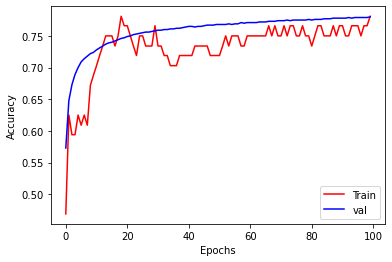

    Epoch  Acc_train  Acc_val  val_loss  train_loss
0     0.0      0.469    0.573     0.677       0.690
1     1.0      0.625    0.648     0.635       0.629
2     2.0      0.594    0.673     0.613       0.634
3     3.0      0.594    0.689     0.598       0.634
4     4.0      0.625    0.700     0.584       0.638
..    ...        ...      ...       ...         ...
95   95.0      0.766    0.779     0.490       0.425
96   96.0      0.750    0.779     0.489       0.426
97   97.0      0.766    0.779     0.488       0.428
98   98.0      0.766    0.779     0.490       0.422
99   99.0      0.781    0.780     0.490       0.426

[100 rows x 5 columns]


In [ ]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_val,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

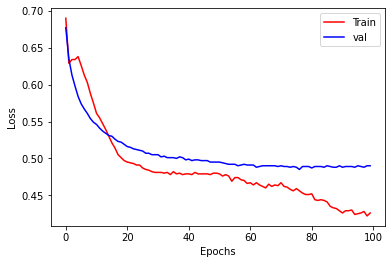

In [ ]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.val_loss,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
classes = ['Different Voice', 'Same Voice']
y_pred = CNN(X1_val, X2_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.79      0.75      0.77     31873
     Same Voice       0.77      0.81      0.79     32127

       accuracy                           0.78     64000
      macro avg       0.78      0.78      0.78     64000
   weighted avg       0.78      0.78      0.78     64000



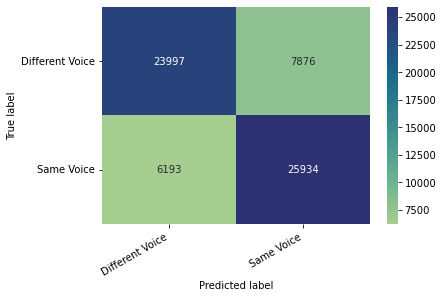

In [ ]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
y_pred = CNN(X1_test, X2_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.79      0.75      0.77     25666
     Same Voice       0.76      0.80      0.78     25534

       accuracy                           0.78     51200
      macro avg       0.78      0.78      0.78     51200
   weighted avg       0.78      0.78      0.78     51200



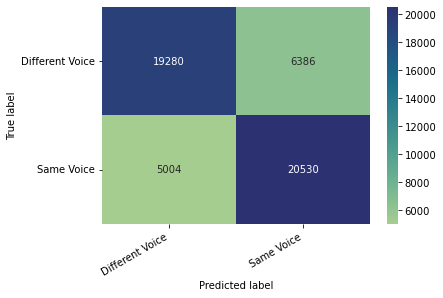

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
